In [ ]:
!pip install pyspark


     |████████████████████████████████| 204.2MB 58kB/s 
     |████████████████████████████████| 204kB 42.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=ae5a3e3c8bb7e13e7a58ab0c7acff474fcd573ab051334d3290197f2ff3254fa
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
import time
spark = SparkSession.builder.master("local").getOrCreate()
conf = SparkConf().setAppName('appname').setMaster("local[*]")
conf.set('spark.driver.memory', '20g')
sc = SparkContext.getOrCreate(conf=conf)
# sc = SparkContext.getOrCreate()


In [ ]:
rdd = sc.parallelize(["Hello Spark"])
counts = rdd.flatMap(lambda line: line.split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()
print(counts)

[('Hello', 1), ('Spark', 1)]


In [ ]:
import pandas as pd
taxifile = []
for i in range(1, 13):
  month = ""
  if i < 10:
    month = "0" + str(i)
  else:
    month = str(i)
  url = '/content/drive/Shared drives/NCTU-1091-Big Data/Homework 1/data/yellow/yellow_tripdata_2019-' + month + '.csv'
  taxicsv = pd.read_csv(url, 
              # usecols=["PULocationID", "DOLocationID"], 
              # dtype={"PULocationID" : "int", "DOLocationID" : "int"}
              # usecols=["tpep_pickup_datetime", "tpep_dropoff_datetime"], 
              usecols=["tpep_dropoff_datetime"], 
              dtype={"tpep_dropoff_datetime" : "str"}
              )
  taxifile.append(taxicsv)
taxifile = pd.concat(taxifile, axis=0, ignore_index=True)
print(taxifile)

KeyboardInterrupt: ignored

In [ ]:
simpleData = [("James","Sales","NY",90000,34,10000),
    ("Michael","Sales","NY",86000,56,20000),
    ("Robert","Sales","CA",81000,30,23000),
    ("Maria","Finance","CA",90000,24,23000),
    ("Raman","Finance","CA",99000,40,24000),
    ("Scott","Finance","NY",83000,36,19000),
    ("Jen","Finance","NY",79000,53,15000),
    ("Jeff","Marketing","CA",80000,25,18000),
    ("Kumar","Marketing","NY",91000,50,21000)
  ]

schema = ["employee_name","department","state","salary","age","bonus"]
df = spark.createDataFrame(data=simpleData, schema = schema)
df.printSchema()
df.show(truncate=False)
df.groupBy("department", "employee_name").count().show(truncate=False)

In [ ]:
# peak hours


a = time.time()
location = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']
rdd = sc.parallelize(taxifile.loc[:, 'tpep_dropoff_datetime'])
counts = rdd.map(lambda datetime: (datetime.split(" ")[1].split(":")[0], 1)) \
      .reduceByKey(lambda a, b: a + b) \
      .collect()

print(time.time() - a, "seconds")
print(max(counts))
location = [[0, 0], [0, 0]]

counts = sorted(counts, key=lambda x:x[1])
for i in range(5):
  print(counts[i], counts[len(counts) - i - 1])



In [ ]:
a = time.time()
location = ['PULocationID', 'DOLocationID']
# rdd = sc.parallelize(taxifile.loc[:, ['PULocationID', 'DOLocationID']].values.tolist())
# counts = rdd.flatMap(lambda x: [(('PU', x[0]), 1), (('DO', x[1]), 1)]) \
#     .reduceByKey(lambda a, b: a + b) \
#     .collect()
rdd = sc.parallelize(taxifile.loc[:, 'DOLocationID'])
counts = rdd.map(lambda x: (x, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

print(time.time() - a, "seconds")
counts = sorted(counts, key=lambda x:x[1])
for i in range(5):
  print(counts[i], counts[len(counts) - i - 1])
location = [[0, 0], [0, 0]]

for i in range(len(counts)):
  if i[0][0] == 'DO':
    if i[1] > location[1][1]:
      location[1][0] = i[0]
      location[1][1] = i[1]
  else:
    if i[1] > location[0][1]:
      location[0][0] = i[0]
      location[0][1] = i[1]
print(location)

95.17246723175049 seconds
(110, 5) (236, 3429838)
(199, 13) (161, 3261232)
(105, 87) (237, 3256021)
(2, 95) (170, 2643630)
(99, 115) (230, 2596508)


TypeError: ignored

In [ ]:
from multiprocessing.dummy import Pool as ThreadPool

# conf = SparkConf().setMaster('local[*]').setAppName('appname')
# conf.set('spark.scheduler.mode', 'FAIR')
# sc = SparkContext.getOrCreate(conf=conf)
a = time.time()
location = ['PULocationID', 'DOLocationID']
def process(sc, location):
  rdd = sc.parallelize(taxifile.loc[:, location]).cache()
  counts = rdd.map(lambda x: (x, 1)) \
      .reduceByKey(lambda a, b: a + b) \
      .collect()
  print(counts)
  return counts
p = ThreadPool(cpu_count())
p.map(process, ['PULocationID', 'DOLocationID'])
print(time.time() - a, "seconds")
# location = [[0, 0], [0, 0]]

# for i in counts:
#   if i[0][0] == 'D':
#     if i[1] > location[1][1]:
#       location[1][0] = i[0]
#       location[1][1] = i[1]
#   else:
#     if i[1] > location[0][1]:
#       location[0][0] = i[0]
#       location[0][1] = i[1]
# print(location)



In [ ]:
import multiprocessing
from multiprocessing import Process, Pool

def main_map(i):
    result = i * i
    return result

inputs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cpus = multiprocessing.cpu_count()
print(cpus)
pool = Pool(cpus)
pool_outputs = pool.map(main_map, inputs)
print(pool_outputs)

In [ ]:
#KMeans

In [ ]:
import pandas as pd

def notzeros(rows, length):
  if rows < 0:
    return False
  if taxifile.loc[rows]["pickup_longitude"] == 0 or taxifile.loc[rows]["pickup_latitude"] == 0 or taxifile.loc[rows]["dropoff_longitude"] == 0 or taxifile.loc[rows]["dropoff_latitude"] == 0:
    return True
  return False

taxifile = []
url = '/content/drive/Shared drives/NCTU-1091-Big Data/Homework 1/data/yellow/yellow_tripdata_2016-06.csv'
taxifile = pd.read_csv(url, 
            usecols=["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"], 
            dtype={"pickup_longitude" : "float", "pickup_latitude" : "float", "dropoff_longitude" : "float", "dropoff_latitude" : "float"}
            )
# nonefile = taxifile.query('pickup_longitude == 0 or pickup_latitude == 0 or dropoff_longitude == 0 or dropoff_latitude == 0')
print(taxifile)

          pickup_longitude  ...  dropoff_latitude
0               -73.983360  ...         40.753979
1               -73.981720  ...         40.670242
2               -73.994316  ...         40.742168
3               -73.982361  ...         40.851540
4               -73.987106  ...         40.766445
...                    ...  ...               ...
11135465        -73.971756  ...         40.761093
11135466        -73.989693  ...         40.747814
11135467        -73.973473  ...         40.743172
11135468        -73.936806  ...         40.726055
11135469        -73.991432  ...         40.768871

[11135470 rows x 4 columns]


In [ ]:
print(taxifile.loc[0])
print(taxifile.loc[0][1], taxifile.loc[0][2])
for i in range(len(taxifile.loc[0])):
  print(taxifile.loc[0][i])

pickup_longitude    -73.983360
pickup_latitude      40.760937
dropoff_longitude   -73.977463
dropoff_latitude     40.753979
Name: 0, dtype: float64
40.76093673706055 -73.97746276855469
-73.98336029052734
40.76093673706055
-73.97746276855469
40.75397872924805


[[-73.98336029052734, 40.76093673706055], [-73.98171997070312, 40.73666763305664], [-73.99431610107422, 40.75107192993164], [-73.98236083984375, 40.77389144897461], [-73.98710632324219, 40.73317337036133]]
99 -73.96500396728516


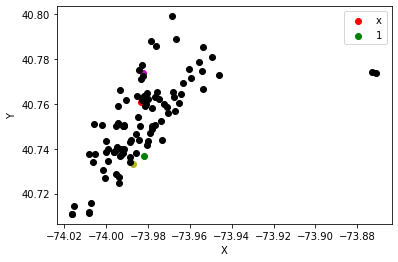

In [ ]:
# KMeans
import matplotlib.pyplot as plt  
import random

center = []
locationclass = [1 for i in range(len(taxifile))]
for i in range(5):
  # index = random.randint(0, len(taxifile)-1)
  center.append([taxifile.loc[i][0], taxifile.loc[i][1]])
print(center)
print(len(locationclass), taxifile.loc[98][0])
color = ['k' for i in range(len(taxifile))]
color[0] = 'r'
color[1] = 'g'
color[2] = 'b'
color[3] = 'm'
color[4] = '#b4b21f'
fig = plt.figure() 
plt.xlabel('X')  
plt.ylabel('Y')  
# plt.scatter(taxifile.loc[:, 'pickup_longitude'],taxifile.loc[:, "pickup_latitude"],c=color,marker='s')  
colmap = {0:'r', 1:'g', 2:'b', 3:'#b4b21f', 4:'m'}
for i in range(len(color)):
  plt.scatter(taxifile.loc[i][0],taxifile.loc[i][1],c=color[i])
#設定圖示
plt.legend('x1')  
#顯示所畫的圖
plt.show() 

[[-73.87197875976562, 40.77391242980957], [-73.97906556000581, 40.760624034984694], [-73.9607048034668, 40.77879197256906], [-73.99373111724853, 40.739953422546385], [-74.0118637084961, 40.7125670115153]]


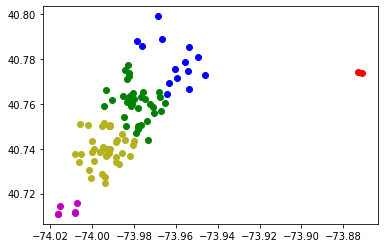

Total：2.8373260498046875 seconds


In [ ]:
import math
import time
import matplotlib.pyplot as plt  

a = time.time()
def Euclidean_distance(x, y):
  distance = 0
  for i in range(2):
    distance += pow((x[i] - y[i]), 2)
  distance = math.sqrt(distance)
  return distance

def KMeans(k, data, center, locationclass, colmap):
  # data = {(60,9):[1, 1], (65,10):[1, 1], (75,15):[1, 1], (80,11):[1, 1], (85,17):[1, 1]}
  # center = [[60,9], [65,10]]
  # x = [12, 20, 28, 18, 29, 33, 24, 45, 45, 52, 51, 52, 55, 53, 55, 61, 64, 69, 72]
  # y = [39, 36, 30, 52, 54, 46, 55, 59, 63, 70, 66, 63, 58, 23, 14, 8, 19, 7, 24]
  tempcenter = [[0, 0] for i in range(k)]
  fig = plt.figure() 
  color = ['k' for i in range(len(data))]
  while (tempcenter != center):
    for i in range(len(center)):
      for j in range(len(center[i])):
        tempcenter[i][j] = center[i][j]
    for i in range(len(data)):
      max = 1000000
      for j in range(len(center)):
        distance = Euclidean_distance(center[j], data.loc[i])
        if distance < max:
          locationclass[i] = j
          max = distance
          color[i] = colmap[j]
    center = [[0, 0] for i in range(k)]
    length = [0 for i in range(k)]
    for i in range(len(data)):
      if (data.loc[i][0] == 0) or (data.loc[i][1] == 0):
        continue
      center[locationclass[i]][0] += data.loc[i][0]
      center[locationclass[i]][1] += data.loc[i][1]
      length[locationclass[i]] += 1
    for i in range(len(center)):
      for j in range(len(center[i])):
        center[i][j] = center[i][j] / length[i]
    
  print(center)
  for i in range(len(color)):
    plt.scatter(data.loc[i][0],data.loc[i][1],c=color[i])
  plt.show()
  
KMeans(5, taxifile, center, locationclass, colmap)
print("Total：{} seconds".format(time.time() - a))



# center = [[12, 39], [20, 36], [18, 52]]
# colmap = {0:'r', 1:'g', 2:'b'}
# locationclass = [1 for i in range(19)]
# k=3
# KMeans(3, k, center, locationclass, colmap)
      

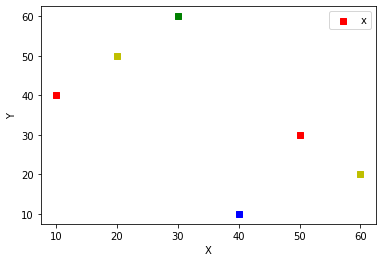

In [ ]:
import numpy as np  
import matplotlib.pyplot as plt  
#產生測試資料
x = [10, 20, 30, 40, 50, 60]
y = [40, 50, 60, 10, 30, 20]
ax1 = plt.figure()  
# ax1 = fig.add_subplot(111)  
# #設定標題
# ax1.set_title('Scatter Plot')  
# #設定X軸標籤
plt.xlabel('X')  
# #設定Y軸標籤
plt.ylabel('Y')  
#畫散點圖
cValue = ['r','y','g','b','r','y']  
plt.scatter(x,y,c=cValue,marker='s')  
#設定圖示
plt.legend('x1')  
#顯示所畫的圖
plt.show()  

In [ ]:
{0: [-73.98336029052734, 40.76093673706055], 1: [-73.98171997070312, 40.73666763305664], 2: [-73.99431610107422, 40.75107192993164], 3: [-73.98236083984375, 40.77389144897461], 4: [-73.98710632324219, 40.73317337036133]}


[[-73.97228892256574, 40.76899923929354], [-73.98241023013466, 40.7440763774671], [-73.99616638183593, 40.74421371459961], [-73.87197875976562, 40.77391242980957], [-74.00516001383464, 40.72066275278727]]
Total：0.9140398502349854 seconds



-73.97228892256574, 40.76899923929354, 0], [-73.98241023013466, 40.7440763774671, 1], [-73.99616638183593, 40.74421371459961, 2], [-73.87197875976562, 40.77391242980957, 3], [-74.00516001383464, 40.72066275278727, 4]]
[-73.98336029052734, 40.76093673706055], [-73.98171997070312, 40.73666763305664], [-73.99431610107422, 40.75107192993164], [-73.98236083984375, 40.77389144897461], [-73.98710632324219, 40.73317337036133]]

In [ ]:
# KMeans + MapReduce
import random


center = []
count = 0
while len(center) < 15:
  index = random.randint(0, len(taxifile)-1)
  if taxifile.loc[index][2] != 0 and taxifile.loc[index][3] != 0:
    center.append([taxifile.loc[index][2], taxifile.loc[index][3], count])
    count+=1
  
print(center)
# locationclass = {i:[100000, 0] for i in range(len(taxifile))}
# print(len(locationclass))
# for i in taxifile.values.tolist():
#   print(i)
#   input(1)

[[-73.98863983154298, 40.7526741027832, 0], [-73.9797134399414, 40.734779357910156, 1], [-73.9527587890625, 40.78915023803711, 2], [-73.9515151977539, 40.77379608154297, 3], [-73.99650573730467, 40.74786758422852, 4], [-73.98477935791014, 40.76241302490234, 5], [-73.99031066894531, 40.73508071899415, 6], [-73.97435760498048, 40.76359558105469, 7], [-74.00823974609375, 40.71357727050781, 8], [-73.98603057861328, 40.767372131347656, 9], [-73.98297119140625, 40.77014923095703, 10], [-73.99880981445312, 40.76118087768555, 11], [-73.99362182617188, 40.702537536621094, 12], [-73.97762298583984, 40.75188827514648, 13], [-74.01760101318358, 40.70676040649415, 14]]


In [ ]:
# KMeans + MapReduce V2

import matplotlib.pyplot as plt 
import time

a = time.time()

def Euclidean_distance(x, y, length):
  max = [0, 1000000]
  if x[0] == 0 or x[1] == 0:
    return [(('x', 0), 0), (('y', 0), 0), (('xy', 0), 0)]
  for i in range(len(y)):
    distance = pow((x[0] - y[i][0]), 2) + pow((x[1] - y[i][1]), 2)
    if distance < max[1]:
      max[1] = distance
      max[0] = i
  length[max[0]] += 1
  return [(('x', max[0]), x[0]), (('y', max[0]), x[1]), (('xy', max[0]), 1)]

# def Euclidean_distance(x, y):
#   maxarray = [0, 1000000]
#   if x[0] == 0 or x[1] == 0:
#     return [(('x', 0), 0), (('y', 0), 0), (('xy', 0), 0)]
  
#   maxarray[0] = y.map(lambda row: (row[2], pow((x[0] - row[0]), 2) + pow((x[1] - row[1]), 2))).reduce(lambda a, b: a if a < b else b)
#   return [(('x', maxarray[0]), x[0]), (('y', maxarray[0]), x[1]), (('xy', maxarray[0]), 1)]


def locationclustering(locationlist, i, k):
  max = [100000, 0]
  max = min(locationlist)
  return max[1]

def KMeans(k, data, center, colmap):
  fig = plt.figure() 
  color = ['k' for i in range(len(data))]
  tempcenter = [[0, 0, i] for i in range(k)]
  rdd = sc.parallelize(data.loc[:, ['pickup_longitude', 'pickup_latitude']].values.tolist())
  while(tempcenter != center):
    
    for i in range(len(center)):
      for j in range(len(center[i])):
        tempcenter[i][j] = center[i][j]
    length = [0 for i in range(k)]
    # rddloc = sc.parallelize(center)
    locationclass = rdd.flatMap(lambda x: Euclidean_distance(x, center, length)).reduceByKey(lambda a, b: a + b).collect()
    print(len(locationclass))
    input()
    center = [[0, 0, i] for i in range(k)]
    for i in range(0, len(locationclass), 3):
      if locationclass[i + 2][1] == 0:
        continue
      center[locationclass[i][0][1]][0] = locationclass[i][1] / locationclass[i + 2][1]
      center[locationclass[i][0][1]][1] = locationclass[i+1][1] / locationclass[i + 2][1]
    print(center)
  return length
    
  print(center)
colmap = {0:'r', 1:'g', 2:'b', 3:'#b4b21f', 4:'m'}
print(KMeans(3, taxifile, center, colmap))
print("Total：{} seconds".format(time.time() - a))
      

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
from random import sample 
yellowtaxi = taxifile.loc[:, ['pickup_longitude', 'pickup_latitude']].values.tolist()
print(sample(yellowtaxi,5)) 

[[-73.99453735351562, 40.740623474121094], [-73.97830963134766, 40.78797912597656], [-73.98802947998048, 40.74383544921875], [-73.97555541992188, 40.76527404785156], [-73.9842758178711, 40.77500915527344]]


In [ ]:
# mini_batch_KMeans + MapReduce V2

import matplotlib.pyplot as plt 
import random 
import time

a = time.time()

def randomselectdata(yellowtaxi):
  taxi = []
  while len(taxi) < 800000:
    index = random.randint(0,len(yellowtaxi) - 1)
    if yellowtaxi[index][0] != 0 and yellowtaxi[index][1] != 0:
      taxi.append(yellowtaxi[index])
  return taxi
  
def Euclidean_distance(x, y, length):
  max = [0, 1000000]
  for i in range(len(y)):
    distance = pow((x[0] - y[i][0]), 2) + pow((x[1] - y[i][1]), 2)
    if distance < max[1]:
      max[1] = distance
      max[0] = i
  return [(('x', max[0]), x[0]), (('y', max[0]), x[1]), (('xy', max[0]), 1)]


def locationclustering(locationlist, i, k):
  max = [100000, 0]
  max = min(locationlist)
  return max[1]

def KMeans(k, data, center, colmap):
  fig = plt.figure() 
  color = ['k' for i in range(len(data))]
  tempcenter = [[0, 0, i] for i in range(k)]
  yellowtaxi = data.loc[:, ['dropoff_longitude', 'dropoff_latitude']].values.tolist()
  nums = 0
  while(tempcenter != center and nums < 100):
    for i in range(len(center)):
      for j in range(len(center[i])):
        if center[i][j] == 0 and j != 2:
          break
        else:
          tempcenter[i][j] = center[i][j]
    length = [0 for i in range(k)]
    # rddloc = sc.parallelize(center)
    selected = randomselectdata(yellowtaxi)
    for i in selected:
      if i[0] == 0 or i[1] == 0:
        print(1)
    rdd = sc.parallelize(randomselectdata(yellowtaxi))
    locationclass = rdd.flatMap(lambda x: Euclidean_distance(x, center, length)).reduceByKey(lambda a, b: a + b).collect()
    # center = [[0, 0, i] for i in range(k)]
    for i in range(0, len(locationclass), 3):
      center[locationclass[i][0][1]][0] = locationclass[i][1] / locationclass[i + 2][1]
      center[locationclass[i][0][1]][1] = locationclass[i+1][1] / locationclass[i + 2][1]
      length[int(i/3)] = locationclass[i + 2][1]
    print(length)
    # print(center)
    nums+=1
  print(nums, center)
  return length
colmap = {0:'r', 1:'g', 2:'b', 3:'#b4b21f', 4:'m'}
print(KMeans(15, taxifile, center, colmap))
print("Total：{} seconds".format(time.time() - a))
      

[80173, 34249, 58741, 117483, 52390, 49739, 73875, 76916, 33116, 81622, 14892, 46629, 17326, 50490, 12359]
[74947, 70167, 59675, 50163, 43938, 136107, 48464, 27876, 63470, 22560, 71580, 27768, 82568, 3101, 17616]
[82487, 74780, 137556, 32158, 66602, 21101, 51231, 61141, 88065, 50723, 21851, 33474, 51833, 25030, 1968]
[28675, 130819, 80953, 84002, 16832, 80594, 39349, 36934, 89029, 21708, 47717, 58284, 29625, 53641, 1838]
[87760, 19801, 84174, 57304, 123995, 84903, 42685, 47259, 79048, 56484, 28127, 28649, 19331, 38636, 1844]
[58708, 47218, 119281, 74551, 91200, 18743, 46607, 54934, 23381, 26724, 79380, 46184, 89972, 21151, 1966]
[70623, 18739, 92133, 115685, 48499, 54691, 92888, 61174, 54111, 76204, 27127, 46269, 19787, 20179, 1891]
[54831, 52061, 68846, 74220, 89265, 26998, 93980, 18484, 63967, 63099, 111057, 45834, 19268, 16254, 1836]
[64940, 46588, 72570, 95043, 87360, 105401, 70169, 56376, 26941, 54022, 18611, 19126, 13710, 67341, 1802]
[66820, 66658, 76586, 101047, 45436, 95380, 7

<Figure size 432x288 with 0 Axes>

In [ ]:
93123, 22067, 103955, 20575, 111943, 105086, 100659, 87175, 51604, 11153, 52516, 14790, 1820, 20506, 3028

[-73.99732644093638, 40.74738465548078, 0[68]], 
[-73.8629086820736, 40.88522368094723, 2[237]], 
[-73.9927559033461, 40.728088002738346, 4[79]], 
[-73.96542592311481, 40.76278102814088, 5[141]], 
[-73.9443874076389, 40.70329781755932, 6], 
[-73.94993702482897, 40.77794845419146, 7[80]], 

In [ ]:
import time
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.cluster.hierarchy import leaves_list, is_valid_linkage
from scipy.spatial.distance import squareform, is_valid_y, is_valid_dm
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import leaves_list, dendrogram

try:
    from fastcluster import linkage
except ImportError:
    from scipy.cluster.hierarchy import linkage


def get_cell_data(n=50, seed=0):
    np.random.seed(seed)
    cells_data = np.load('./data/cells_data.npy')

    sample_cells = np.random.choice(cells_data.shape[0], n, replace=False)

    D = pdist(cells_data[sample_cells, :], 'euclidean')
    Z = linkage(D, 'ward')

    return cells_data, Z, D

def get_random_data(n=50, seed=0):

    np.random.seed(seed)
    data = np.random.choice(10000, (n, 1), replace=False)
    D = pdist(data, 'euclidean')
    Z = linkage(D, 'ward')
    return data, Z, D

def optimal_leaf_ordering(Z, D):
    """
    Compute the optimal leaf order for Z (according to D)
    and return an optimally sorted Z. 
    We start by sorting and relabelling Z and D according to the
    current leaf order in Z.
    
    This is because when everything is sorted each cluster (including singletons)
    can be defined by its range over (0...n_points).
    This is used extensively loop efficiently over the various arrays in the algorithm.
    """
    if not is_valid_linkage(Z):
        raise("Not a valid linkage map. ")
    
    if is_valid_y(D):
        sorted_D = squareform(D)
    elif is_valid_dm(D):
        sorted_D = D
        pass
    else:
        raise("Not a valid distance matrix (neither condensed nor square forms)")

    n_points = Z.shape[0] + 1
    n_clusters = 2*n_points - 1

    # Get the current linear ordering
    sorted_leaves = leaves_list(Z)

    # Create map from original order to sorted order.
    original_order_to_sorted_order = dict((orig_i, sorted_i) for sorted_i, orig_i in enumerate(sorted_leaves))


    # Re-write linkage map so it refers to sorted positions, rather than input positions
    # Remove the 'height' column so we can cast the whole thing as integer and simplify passing to C function above.
    sorted_Z = []
    for (v_l, v_r, _, v_size) in Z:
        if v_l < n_points:
            v_l = original_order_to_sorted_order[int(v_l)]
        if v_r < n_points:
            v_r = original_order_to_sorted_order[int(v_r)]
        
        sorted_Z.append([v_l, v_r, v_size])
    sorted_Z = np.array(sorted_Z).astype(np.int32).copy(order='C')


    # Sort distance matrix D by the leaf order
    sorted_D = sorted_D[sorted_leaves, :]
    sorted_D = sorted_D[:, sorted_leaves].copy(order='C')

    # Defines the range of each cluster over (0... n_points) as explained above. 
    cluster_ranges = np.zeros((n_clusters, 2))
    cluster_ranges[np.arange(n_points), 0] = np.arange(n_points)
    cluster_ranges[np.arange(n_points), 1] = np.arange(n_points) + 1
    for link_i, (v_l, v_r, v_size) in enumerate(sorted_Z):
        v = link_i + n_points
        cluster_ranges[v, 0] = cluster_ranges[v_l, 0]
        cluster_ranges[v, 1] = cluster_ranges[v_r, 1]
    cluster_ranges = cluster_ranges.astype(np.int32).copy(order='C')

    # Get Swaps 
    must_swap = identify_swaps(sorted_Z, sorted_D, cluster_ranges)


    """
    To 'rotate' around the axis of a node, we need to the left-right children
    of every descendant of this target node.
    
    Do so efficiently, we record how many total times a given node must be swapped
    (once if it needs to be swapped itself, once for each parent that needs to be swapped) 
    and take modulo 2 to find wether it needs to be swapped at all. 
    """

    is_cluster_descendant = np.zeros((n_clusters - n_points, n_clusters - n_points), dtype=int)
    for i, (v_l, v_r, v_size) in enumerate(sorted_Z):
        is_cluster_descendant[i, i] = 1
        if v_l >= n_points:
            is_cluster_descendant[i, v_l - n_points] = 1
            is_cluster_descendant[i, :] += is_cluster_descendant[v_l - n_points, :]
        if v_r >= n_points:
            is_cluster_descendant[i, v_r - n_points] = 1
            is_cluster_descendant[i, :] += is_cluster_descendant[v_r - n_points, :]


    # To "rotate" a tree node, we need to 'swap' it's left-right children, and do the same do all it's children. 
    applied_swap = np.array(is_cluster_descendant).astype(bool) * np.array(must_swap).reshape(-1, 1)
    final_swap = applied_swap.sum(axis=0) % 2

    # Create a new linkage matrix by applying swaps where needed. 
    swapped_Z = []
    for i, (in_l, in_r, h, v_size) in enumerate(Z):
        if final_swap[i]:
            out_l = in_r
            out_r = in_l
        else:
            out_r = in_r
            out_l = in_l   
        swapped_Z.append((out_l, out_r, h, v_size))
    swapped_Z = np.array(swapped_Z)

    return swapped_Z

def run_polo(Z, D):
    # from polo import optimal_leaf_ordering

    start_time = time.time()
    best_Z = optimal_leaf_ordering(Z, D)
    end_time = time.time()
    return end_time - start_time, best_Z


def run_orange3(Z, D):
    import Orange.clustering.hierarchical as orange_hier

    tree = orange_hier.tree_from_linkage(Z)
    start_time = time.time()
    orange_hier.optimal_leaf_ordering(tree, squareform(D))
    end_time = time.time()
    return end_time - start_time, None


def benchmark():
    random_data = []
    for n in range(4, 12):
        for i in range(3):
            data, z, d = get_random_data(2**n, i)
            polo_time, _ = run_polo(z, d)
            print(n, i, polo_time)
            random_data.append([n, i, polo_time])
    np.save('./data/random_data_benchmark.npy', np.array(random_data))

    cells_data = []
    for n in range(4, 13):
        for i in range(3):
            data, z, d = get_cell_data(2**n, i)
            polo_time, _ = run_polo(z, d)
            print(n, i, polo_time)
            cells_data.append([n, i, polo_time])
    np.save('./data/real_data_benchmark.npy', np.array(cells_data))
    
    orange_data = []
    for n in range(4, 12):
        for i in range(3):
            data, z, d = get_cell_data(2**n, i)
            oj_time, _ = run_orange3(z, d)
            print(n, i, oj_time)
            orange_data.append([n, i, oj_time])
    np.save('./data/real_data_orange3_benchmark.npy', np.array(orange_data))

def make_benchmark_figure():

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1, xscale='linear', yscale='log')


    d1 = np.load('./data/random_data_benchmark.npy')
    d2 = np.load('./data/real_data_benchmark.npy')
    d3 = np.load('./data/real_data_orange3_benchmark.npy')

    ax.scatter(d1[:24, 0], d1[:24, 2], c='r', edgecolor='none', label='Random Data (Polo)')
    ax.scatter(d2[:24, 0], d2[:24, 2], c='green', edgecolor='none', label='Gene expression data (Polo)')
    ax.scatter(d3[:24, 0], d3[:24, 2], c='blue', edgecolor='none', label='Gene expression data (Orange3)')

    ax.legend(loc=2)
    ax.grid('on')
    ax.set_xlabel('log2(Number of leaves)')
    ax.set_ylabel('Run time, seconds')
    fig.tight_layout()
    fig.savefig('data/bench.png', dpi=75)

def make_figure():
    gs = gridspec.GridSpec(5, 1,
                       height_ratios=[3, 1, 2, 3, 1],
                       hspace=0)

    data, Z, D = get_random_data(100, 0)
    order = leaves_list(Z)


    runtime, opt_Z = run_polo(Z, D)
    opt_order = leaves_list(opt_Z)

    fig = plt.figure(figsize=(5,5))
    axd1 = fig.add_subplot(gs[0,0])
    axd1.set_title("Random numbers, clustered using Ward's criterion, default linear ordering.", fontsize=9)
    dendrogram(Z, ax=axd1, link_color_func=lambda k: 'k')
    axd1.set_xticklabels(data[order].reshape(-1))
    axd1.set_xticks([])
    axd1.set_yticks([])

    axh1 = fig.add_subplot(gs[1,0])
    axh1.matshow(data[order].reshape((1,-1)), aspect='auto', cmap='RdBu', vmin=0, vmax=10000)
    axh1.set_xticks([])
    axh1.set_yticks([])

    axd2 = fig.add_subplot(gs[3,0])
    axd2.set_title("The same hierarchical clustering, arranged for optimal linear ordering.", fontsize=9)
    dendrogram(opt_Z, ax=axd2, link_color_func=lambda k: 'k')
    axd2.set_xticklabels(data[opt_order].reshape(-1))
    axd2.set_xticks([])
    axd2.set_yticks([])

    axh2 = fig.add_subplot(gs[4,0])
    axh2.matshow(data[opt_order].reshape((1,-1)), aspect='auto', cmap='RdBu', vmin=0, vmax=10000)
    axh2.set_xticks([])
    axh2.set_yticks([])

    fig.savefig('data/demo.png', dpi=130)


if __name__=="__main__":
    make_figure()
    # benchmark()
    #make_benchmark_figure()

NameError: ignored